In [1]:
import torch
import numpy as np
from scipy.optimize import basinhopping

/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
from scipy.optimize import dual_annealing

import matplotlib.pyplot as plt
import sympy
from sympy import symbols


from itertools import product
import copy
import time

def round_expr(expr, num_digits):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sympy.Number)})

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'Using {device}')

Using cpu


### Testing $−0.814\sin(0.327𝑥2−2.78)\cos(1.64𝑥2+0.254𝑥)$
Doesn't work...

In [4]:
n_params = 6
a = np.random.randn(n_params)
switch = [1, 1, 1, 1, 1, 0]
a = a * switch
x = np.arange(-10, 10, 0.1)
def func(a, x, module):
    cos = module.cos(a[3]*x+a[4]*x**2)
    sin = module.sin(a[1]+a[2]*x**2)
    return a[0]*sin*cos + a[5]*sin
loss = lambda coeff: np.sum((y - func(coeff, x, np))**2)
y = func(a, x, np)
lw = [-10] * n_params
up = [10] * n_params
print(a)

[-1.13241164 -0.75393727  0.25950726 -0.4284018   1.03701882 -0.        ]


In [5]:
x_sym = symbols('x')

target_expr = func(a, x_sym, sympy)
target_expr = round_expr(target_expr, 3)
target_expr

-1.132*sin(0.26*x**2 - 0.754)*cos(1.037*x**2 - 0.428*x)

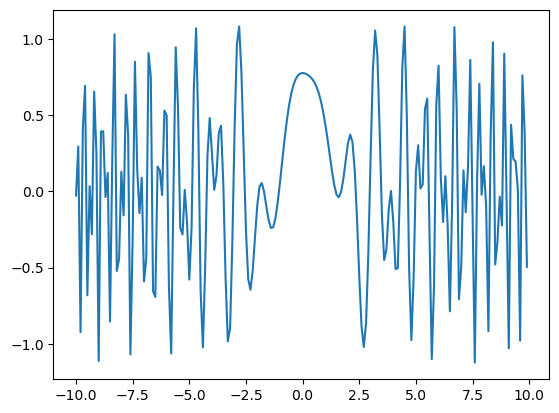

In [6]:
plt.plot(x, y)

In [6]:
x_0 = np.random.randn(n_params)

In [7]:
t_0 = time.time()
ret = basinhopping(loss, x0=x_0, niter=5000)
t_1 = time.time()
print(f'Training time: {t_1 - t_0}')

Training time: 34.19529724121094


In [8]:
ret.x

array([  0.20934604,  -5.52264034,   1.92192016,   1.65498794,
       -14.77042246,   0.22396555])

l_2-distance: 4.944787538242568


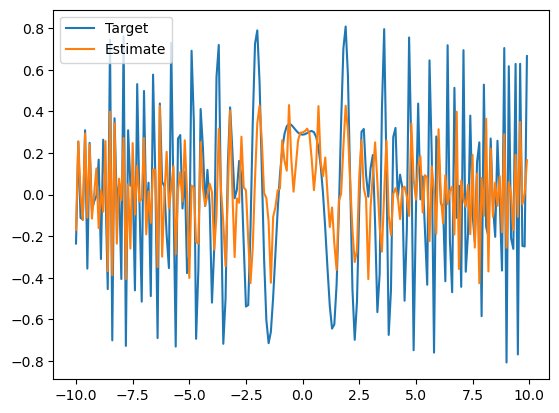

In [9]:
plt.plot(x, y, label='Target')
plt.plot(x, func(ret.x, x, np), label='Estimate')
plt.legend()
print(f'l_2-distance: {np.linalg.norm(y - func(ret.x, x, np), ord=2)}')

In [10]:
estimated_expr = func(ret.x, x_sym, sympy)
estimated_expr = round_expr(estimated_expr, 3)
estimated_expr

0.209*sin(1.922*x**2 - 5.523)*cos(14.77*x**2 - 1.655*x) + 0.224*sin(1.922*x**2 - 5.523)

In [11]:
target_expr

-0.814*sin(0.327*x**2 - 2.78)*cos(1.64*x**2 + 0.254*x)

### Learning $2.604x\sin(0.56x + 2.795) + 3.827x$ from $a_0x + a_1x\sin(a_2 + a_3x + a_4x^2)$

In [7]:
n_params = 5
a = np.array([3.827, 2.604, 2.795, 0.56, 0]) # np.random.randn(n_params) * 3
switch = [1, 1, 1, 1, 0]
a = a * switch
x = np.arange(-10, 10, 0.1)
def func(a, x, module):
    sin = module.sin(a[2]+a[3]*x+a[4]*x**2)
    return a[0]*x + a[1]*sin
loss = lambda coeff: np.sum((y - func(coeff, x, np))**2)
y = func(a, x, np)
lw = [-10] * n_params
up = [10
     ] * n_params
print(a)

[3.827 2.604 2.795 0.56  0.   ]


In [8]:
x_sym = symbols('x')

target_expr = func(a, x_sym, sympy)
target_expr = round_expr(target_expr, 3)
target_expr

3.827*x + 2.604*sin(0.56*x + 2.795)

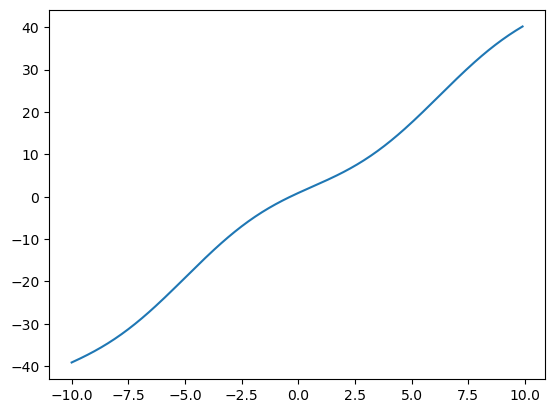

In [9]:
plt.plot(x, y)

In [10]:
x_0 = np.random.randn(n_params)
t_0 = time.time()
ret = basinhopping(loss, x0=x_0, niter=5000)
t_1 = time.time()
print(f'Training time: {t_1 - t_0}')

Training time: 65.07606506347656


In [11]:
ret.x

array([ 3.82700002e+00, -2.60399991e+00, -6.31784458e+01,  5.59999984e-01,
       -3.12064852e-09])

Relative l_2-distance: 1.1555892937526147e-08


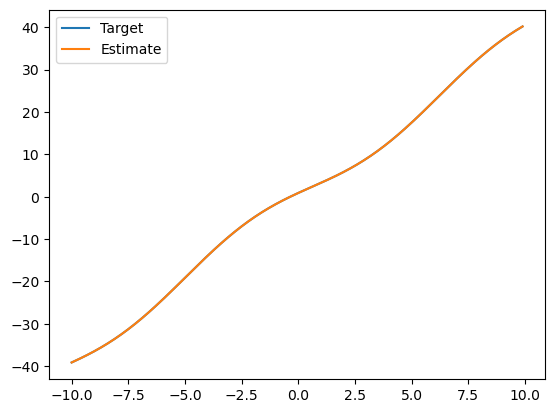

In [12]:
plt.plot(x, y, label='Target')
plt.plot(x, func(ret.x, x, np), label='Estimate')
plt.legend()
print(f'Relative l_2-distance: {np.linalg.norm(y - func(ret.x, x, np), ord=2) / np.linalg.norm(y - y.mean())}')

In [13]:
estimated_expr = func(ret.x, x_sym, sympy)
estimated_expr = round_expr(estimated_expr, 3)
estimated_expr

3.827*x - 2.604*sin(0.56*x - 63.178)

In [14]:
target_expr

3.827*x + 2.604*sin(0.56*x + 2.795)

### Learning $1.292x\sin(1.881x)$ from $a_2xsin(a_0 + a_1x)$

#### Using the formula directly

In [69]:
n_params = 3
a = np.array([0, 1.881, 1.292])
x = np.arange(-10, 10, 0.1)
def func(a, x, module):
    sin = module.sin(a[0]+a[1]*x)
    return a[2]*x*sin
loss = lambda coeff: np.sum((y - func(coeff, x, np))**2)
y = func(a, x, np)
print(a)

[0.    1.881 1.292]


In [70]:
x_sym = symbols('x')

target_expr = func(a, x_sym, sympy)
target_expr = round_expr(target_expr, 3)
target_expr

1.292*x*sin(1.881*x)

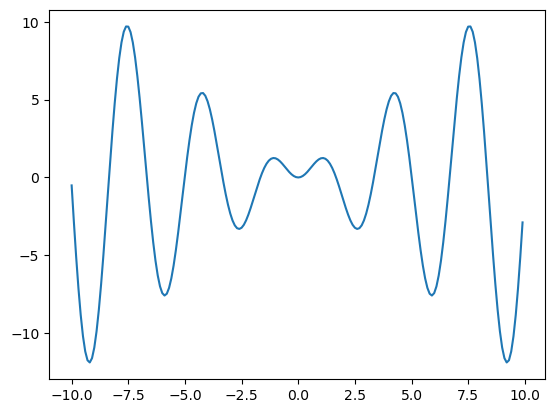

In [71]:
plt.plot(x, y)

In [72]:
x_0 = np.random.randn(n_params)
t_0 = time.time()
ret = basinhopping(loss, x0=x_0, niter=50)
t_1 = time.time()
print(f'Training time: {t_1 - t_0}')

Training time: 0.29320597648620605


In [73]:
ret.x

array([-1.33701295e-08,  1.88099999e+00,  1.29199998e+00])

Relative l_2-distance: 4.203710175680759e-08


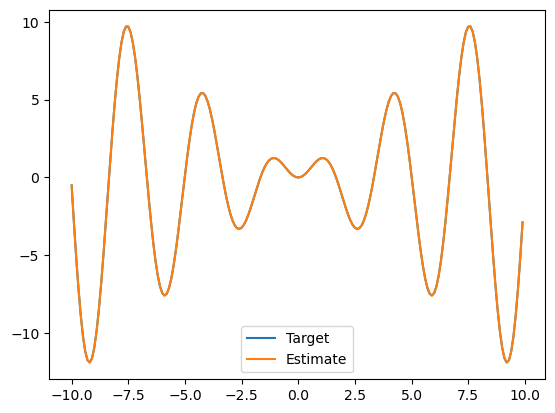

In [74]:
plt.plot(x, y, label='Target')
plt.plot(x, func(ret.x, x, np), label='Estimate')
plt.legend()
print(f'Relative l_2-distance: {np.linalg.norm(y - func(ret.x, x, np), ord=2) / np.linalg.norm(y - y.mean())}')

In [75]:
estimated_expr = func(ret.x, x_sym, sympy)
estimated_expr = round_expr(estimated_expr, 3)
estimated_expr

1.292*x*sin(1.881*x)

In [76]:
target_expr

1.292*x*sin(1.881*x)

### Using ParFamTorch

In [47]:
import os
import sys

In [48]:
sys.path

['/home/philipp/projects/phyiscalLawLearning/ForNet/ParFamTorch/trainingOnSyntheticData',
 '/home/philipp/anaconda3/envs/srbench/lib/python310.zip',
 '/home/philipp/anaconda3/envs/srbench/lib/python3.10',
 '/home/philipp/anaconda3/envs/srbench/lib/python3.10/lib-dynload',
 '',
 '/home/philipp/.local/lib/python3.10/site-packages',
 '/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages',
 '/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/mpmath-1.2.1-py3.10.egg']

In [49]:
os.getcwd()
sys.path.append(os.path.dirname(os.getcwd()))

In [77]:
from parfam_torch import ParFamTorch, Evaluator

In [107]:
functions = [torch.sin, lambda x: torch.sqrt(torch.abs(x))]
function_names = [sympy.sin, lambda x: sympy.sqrt(sympy.Abs(x))]
model = ParFamTorch(n_input=1, degree_input_polynomials=1, degree_output_polynomials=2, width=1,
                        functions=functions, function_names=function_names, maximal_potence=2,
                        degree_output_polynomials_specific=[1, 1], enforce_function=False,
                        degree_input_denominator=0, degree_output_denominator=0, normalize_denom=True,
                        degree_output_polynomials_denominator_specific=[1], device='cpu')

In [82]:
x = torch.tensor(x)
x = x.reshape((len(x), 1))
y = torch.tensor(y)

/tmp/ipykernel_12514/2093916290.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
/tmp/ipykernel_12514/2093916290.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


In [118]:
n_params = model.get_number_parameters()

mask = [True, True, False, False, False, 
        False, False, False, False, False, 
        True, False]
# mask = None
evaluator = Evaluator(x, y, model=model, lambda_0=0, lambda_1=0.001, lambda_denom=0, n_params=n_params, mask=mask)
model.prepare_input_monomials(x)

if mask is None:
    active_params = model.get_number_parameters()
else:
    active_params = sum(mask)

print(f'Number parameters: {active_params}')

Number parameters: 3


In [119]:
t_0 = time.time()
x0 = np.random.randn(active_params)
ret = basinhopping(evaluator.loss_func, niter=50, x0=x0, minimizer_kwargs={'jac': evaluator.gradient})
t_1 = time.time()
print(f'Training time: {t_1 - t_0}')
model.testing_mode()

Training time: 3.597429037094116


Relative l_2-distance: 14.142135683242744


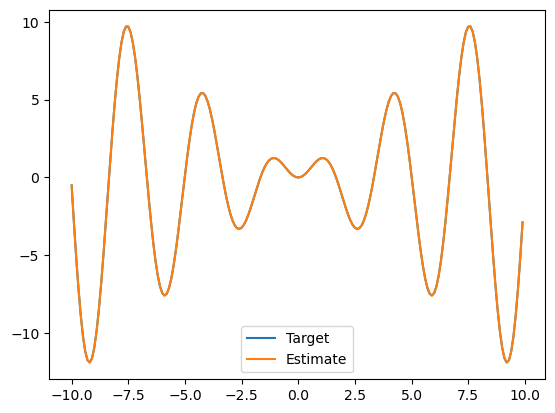

In [120]:
plt.plot(x, y, label='Target')
plt.plot(x, func(ret.x, x, np), label='Estimate')
plt.legend()
print(f'Relative l_2-distance: {np.linalg.norm(y - func(ret.x, x, np), ord=2) / np.linalg.norm(y - y.mean())}')

In [121]:
coefficients = torch.zeros(n_params, device=device, dtype=torch.double)
coefficients[mask] = torch.tensor(ret.x, device=device, dtype=torch.double)
if mask is not None:
    symbolic_a = [symbols(f'a{i}') if mask[i] else 0 for i in range(n_params)]
else:
    symbolic_a = [symbols(f'a{i}') for i in range(n_params)]
print(f'Coefficients: {coefficients}')
print(
    f'Training RMSE: {torch.norm(torch.tensor(y, device=device, dtype=torch.double) - model.predict(coefficients, x), p=2)}')
symbolic_expr = model.get_formula(symbolic_a, verbose=False)
print(f'Symbolic expression: {symbolic_expr}')
print(f'Formula: {model.get_formula(coefficients)}')
print(f'Target expression: {target_expr}')

Coefficients: tensor([-8.5586e-10,  1.8810e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.2920e+00,  0.0000e+00], dtype=torch.float64)
Training RMSE: 2.651752456904701e-06
Symbolic expression: a10*x0*sin(1.0*a0 + 1.0*a1*x0)
Formula: 1.292*x0*sin(1.881*x0)
Target expression: 1.292*x*sin(1.881*x)


/tmp/ipykernel_12514/1721219779.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f'Training RMSE: {torch.norm(torch.tensor(y, device=device, dtype=torch.double) - model.predict(coefficients, x), p=2)}')


In [122]:
ret.x

array([-8.55863414e-10,  1.88100000e+00,  1.29200001e+00])

### Learning $-1.514x\sin(5.534x) + 0.413x\sqrt x$

#### Without ParFamTorch
Doesn't work, so there is no point in trying ParFamTorch for this

In [163]:
n_params = 3
a = torch.tensor([-1.514, 5.534, 0.413])
x = torch.arange(-10, 10, 0.1)
def func(a, x, module):
    return a[0] * module.sin(a[1] * x) + a[2] * x * module.sqrt(module.sqrt(x**2))
loss = lambda coeff: torch.sum((y - func(coeff, x, torch))**2)
y = func(a, x, torch)
print(a)

tensor([-1.5140,  5.5340,  0.4130])


In [164]:
x_sym = symbols('x')

target_expr = func(a, x_sym, sympy)
target_expr = round_expr(target_expr, 3)
target_expr

0.413*x*(x**2)**0.25 - 1.514*sin(5.534*x)

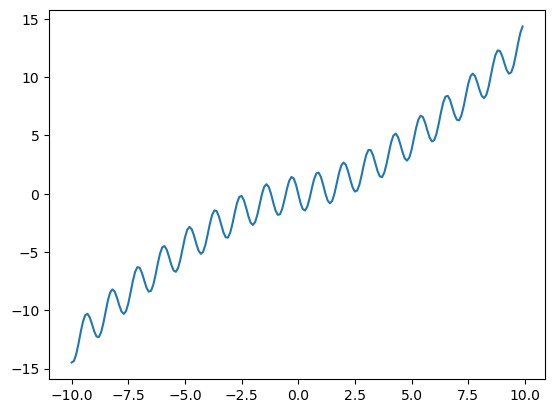

In [165]:
plt.plot(x, y)

In [182]:
x_0 = np.random.randn(n_params)
t_0 = time.time()
ret = basinhopping(loss, x0=x_0, niter=50000)
t_1 = time.time()
print(f'Training time: {t_1 - t_0}')

Training time: 146.14861464500427


In [183]:
ret.x

array([ 1.51340027, -5.53394879,  0.41300171])

Relative l_2-distance: 7.978020585142076e-05


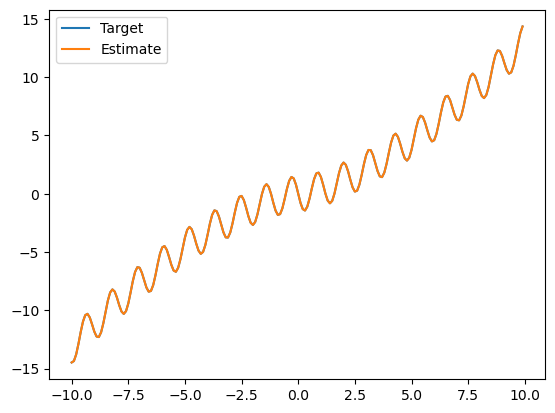

In [184]:
plt.plot(x, y, label='Target')
plt.plot(x, func(ret.x, x, torch), label='Estimate')
plt.legend()
print(f'Relative l_2-distance: {np.linalg.norm(y - func(ret.x, x, torch), ord=2) / np.linalg.norm(y - y.mean())}')

In [185]:
estimated_expr = func(ret.x, x_sym, sympy)
estimated_expr = round_expr(estimated_expr, 3)
estimated_expr

0.413*x*(x**2)**0.25 - 1.513*sin(5.534*x)

In [186]:
target_expr

0.413*x*(x**2)**0.25 - 1.514*sin(5.534*x)

### Learning $-1.514x\sin(5.534x) + 0.413x\sqrt x$

In [ ]:
### 